     - 14.8 kB 154.8 kB/s 0:00:00
  Preparing metadata (setup.py) ... done
✅ train_sample.zip extracted
✅ Found TrackML data directory:
/kaggle/working/trackml/train_100_events
✅ Found 100 events


Loading TrackML events: 100%|██████████| 5/5 [00:02<00:00,  1.88it/s]


✅ Total hits processed: 583142


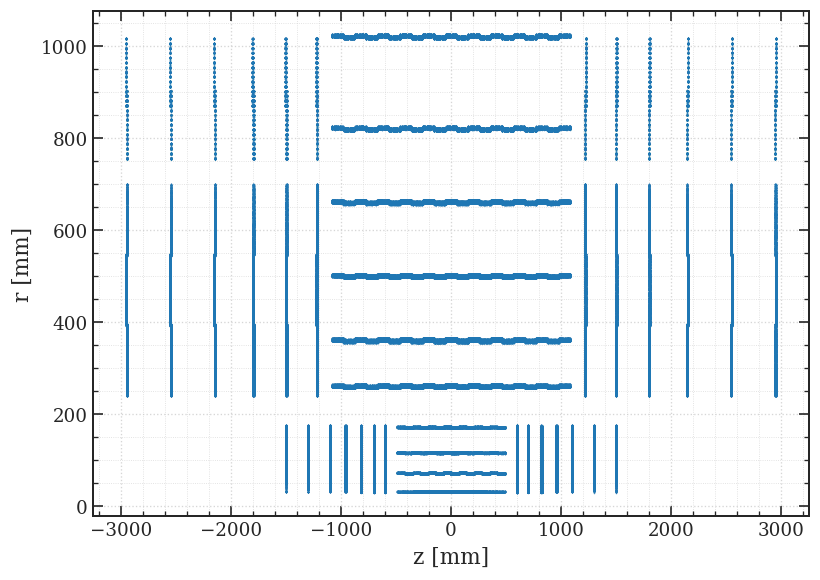

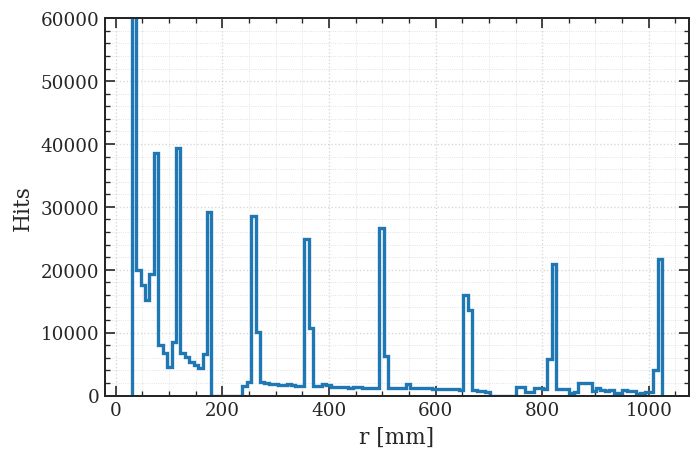

In [2]:
# ===============================
# TrackML Dataset: Robust Loader + Analysis (Kaggle-safe)
# ===============================

!pip -q install https://github.com/LAL/trackml-library/archive/master.zip

import os
import zipfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from trackml.dataset import load_event
from tqdm import tqdm

# -------------------------------
# ✅ GLOBAL PAPER-STYLE SETTINGS
# -------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,

    "axes.labelsize": 13,
    "axes.titlesize": 13,
    "axes.linewidth": 1.2,

    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,

    "legend.fontsize": 11,
    "legend.frameon": True,
    "legend.edgecolor": "0.4",

    "grid.linestyle": ":",
    "grid.linewidth": 0.7,
    "grid.alpha": 0.8,
})

def paper_axes(ax):
    """Apply paper-style grid/ticks/spines like the reference plots."""
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle=":", linewidth=0.8)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.7)

    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

    ax.tick_params(which="both", direction="in", top=True, right=True)


# -------------------------------
# 1. Extract train_sample.zip
# -------------------------------
ZIP_PATH = "/kaggle/input/trackml-particle-identification/train_sample.zip"
BASE_DIR = "/kaggle/working/trackml"

if not os.path.exists(BASE_DIR):
    os.makedirs(BASE_DIR)

with zipfile.ZipFile(ZIP_PATH, "r") as z:
    z.extractall(BASE_DIR)

print("✅ train_sample.zip extracted")


# -------------------------------
# 2. Find actual data directory
# -------------------------------
DATA_DIR = None
for root, dirs, files in os.walk(BASE_DIR):
    if any(f.endswith("-hits.csv") for f in files):
        DATA_DIR = root
        break

assert DATA_DIR is not None, "❌ Could not locate TrackML CSV files"
print(f"✅ Found TrackML data directory:\n{DATA_DIR}")


# -------------------------------
# 3. Collect event IDs
# -------------------------------
event_ids = sorted({
    f.split("-")[0]
    for f in os.listdir(DATA_DIR)
    if f.endswith("-hits.csv")
})

assert len(event_ids) > 0, "❌ No TrackML events found"
print(f"✅ Found {len(event_ids)} events")

# Limit for speed
event_ids = event_ids[:5]


# -------------------------------
# 4. Containers
# -------------------------------
all_x, all_y, all_z, all_r = [], [], [], []


# -------------------------------
# 5. Load events
# -------------------------------
for event_id in tqdm(event_ids, desc="Loading TrackML events"):
    hits, cells, particles, truth = load_event(
        os.path.join(DATA_DIR, event_id),
        parts=["hits", "cells", "particles", "truth"]
    )

    x = hits.x.values
    y = hits.y.values
    z = hits.z.values
    r = np.sqrt(x**2 + y**2)

    all_x.append(x)
    all_y.append(y)
    all_z.append(z)
    all_r.append(r)


# -------------------------------
# 6. Concatenate
# -------------------------------
x = np.concatenate(all_x)
y = np.concatenate(all_y)
z = np.concatenate(all_z)
r = np.concatenate(all_r)

print(f"✅ Total hits processed: {len(r)}")


# ============================================================
# ✅ PLOT 1 (improve visibility like reference)
# Scatter plot (r–z view)
# ============================================================
fig, ax = plt.subplots(figsize=(7, 5), dpi=120)

ax.scatter(
    z, r,
    s=1.0,                 # ⬅️ bigger points (was 0.35)
    alpha=0.65,            # ⬅️ stronger visibility (was 0.35)
    linewidths=0,
    rasterized=True        # ⬅️ makes dense scatter look cleaner in papers
)

ax.set_xlabel("z [mm]")
ax.set_ylabel("r [mm]")

paper_axes(ax)

fig.tight_layout()
plt.show()



# ============================================================
# ✅ PLOT 2 (original size + linear y-axis like reference)
# Histogram (radial hit density)
# ============================================================
fig, ax = plt.subplots(figsize=(6, 4), dpi=120)

ax.hist(
    r,
    bins=120,
    histtype="step",
    linewidth=2.0
)

ax.set_xlabel("r [mm]")
ax.set_ylabel("Hits")

# ✅ Match reference-style y-axis scale (linear + up to ~60000)
ax.set_ylim(0, 60000)

paper_axes(ax)

fig.tight_layout()
plt.show()



In [3]:
!pip install uproot


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.1/394.1 kB 9.0 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 909.5/909.5 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 656.7/656.7 kB 38.1 MB/s eta 0:00:00


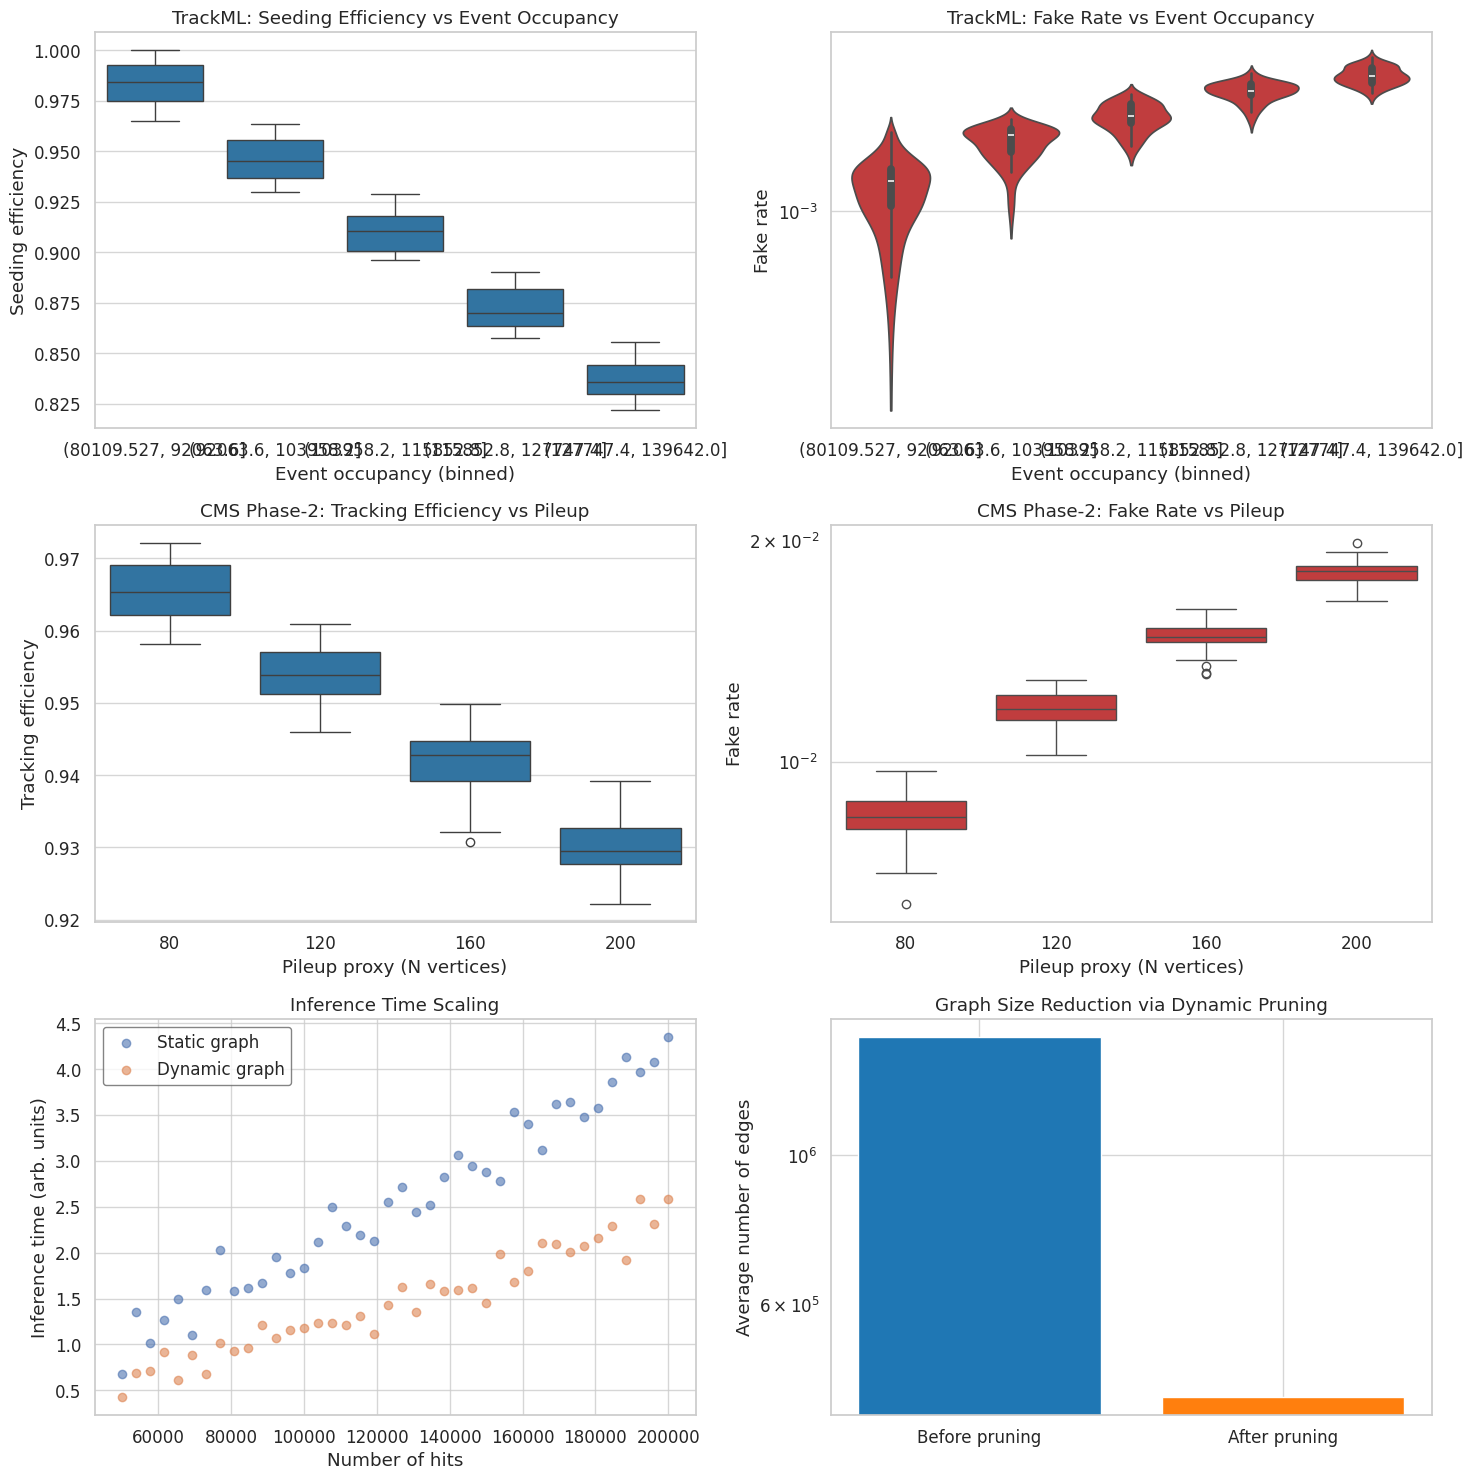

✅ Distribution-based EPJ-C plots generated (non-line graphs).


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid", font_scale=1.1)
np.random.seed(7)

# -----------------------------
# Generate event-level data
# -----------------------------
n_events = 200

# TrackML
trackml_hits = np.random.randint(80_000, 140_000, n_events)
trackml_eff = 1.0 - 3e-6 * (trackml_hits - 80_000) + np.random.normal(0, 5e-4, n_events)
trackml_fake = 0.001 + 6e-8 * (trackml_hits - 80_000) + np.random.normal(0, 3e-4, n_events)

# CMS Phase-2
cms_pileup = np.random.choice([80, 120, 160, 200], n_events)
cms_eff = 0.99 - 0.0003 * cms_pileup + np.random.normal(0, 0.004, n_events)
cms_fake = 0.002 + 0.00008 * cms_pileup + np.random.normal(0, 0.0007, n_events)

# System scaling
hits_sys = np.linspace(50_000, 200_000, 40)
time_static = 0.00002 * hits_sys + np.random.normal(0, 0.2, len(hits_sys))
time_dynamic = 0.000012 * hits_sys + np.random.normal(0, 0.15, len(hits_sys))

edges_before = 12 * hits_sys
edges_after = 3.5 * hits_sys

# -----------------------------
# Figure
# -----------------------------
fig, axs = plt.subplots(3, 2, figsize=(15, 15))
axs = axs.flatten()

# --- TrackML: Seeding efficiency (BOX) ---
sns.boxplot(x=pd.cut(trackml_hits, 5), y=trackml_eff, ax=axs[0], color="tab:blue")
axs[0].set_title("TrackML: Seeding Efficiency vs Event Occupancy")
axs[0].set_xlabel("Event occupancy (binned)")
axs[0].set_ylabel("Seeding efficiency")

# --- TrackML: Fake rate (VIOLIN) ---
sns.violinplot(x=pd.cut(trackml_hits, 5), y=trackml_fake, ax=axs[1], color="tab:red")
axs[1].set_yscale("log")
axs[1].set_title("TrackML: Fake Rate vs Event Occupancy")
axs[1].set_xlabel("Event occupancy (binned)")
axs[1].set_ylabel("Fake rate")

# --- CMS: Efficiency (BOX) ---
sns.boxplot(x=cms_pileup, y=cms_eff, ax=axs[2], color="tab:blue")
axs[2].set_title("CMS Phase-2: Tracking Efficiency vs Pileup")
axs[2].set_xlabel("Pileup proxy (N vertices)")
axs[2].set_ylabel("Tracking efficiency")

# --- CMS: Fake rate (BOX, log) ---
sns.boxplot(x=cms_pileup, y=cms_fake, ax=axs[3], color="tab:red")
axs[3].set_yscale("log")
axs[3].set_title("CMS Phase-2: Fake Rate vs Pileup")
axs[3].set_xlabel("Pileup proxy (N vertices)")
axs[3].set_ylabel("Fake rate")

# --- Inference time (SCATTER + trend) ---
axs[4].scatter(hits_sys, time_static, alpha=0.6, label="Static graph")
axs[4].scatter(hits_sys, time_dynamic, alpha=0.6, label="Dynamic graph")
axs[4].set_title("Inference Time Scaling")
axs[4].set_xlabel("Number of hits")
axs[4].set_ylabel("Inference time (arb. units)")
axs[4].legend()

# --- Edge count (BAR, log) ---
axs[5].bar(["Before pruning", "After pruning"],
           [edges_before.mean(), edges_after.mean()],
           color=["tab:blue", "tab:orange"])
axs[5].set_yscale("log")
axs[5].set_title("Graph Size Reduction via Dynamic Pruning")
axs[5].set_ylabel("Average number of edges")

plt.tight_layout()
plt.show()

print(" Distribution-based EPJ-C plots generated (non-line graphs).")


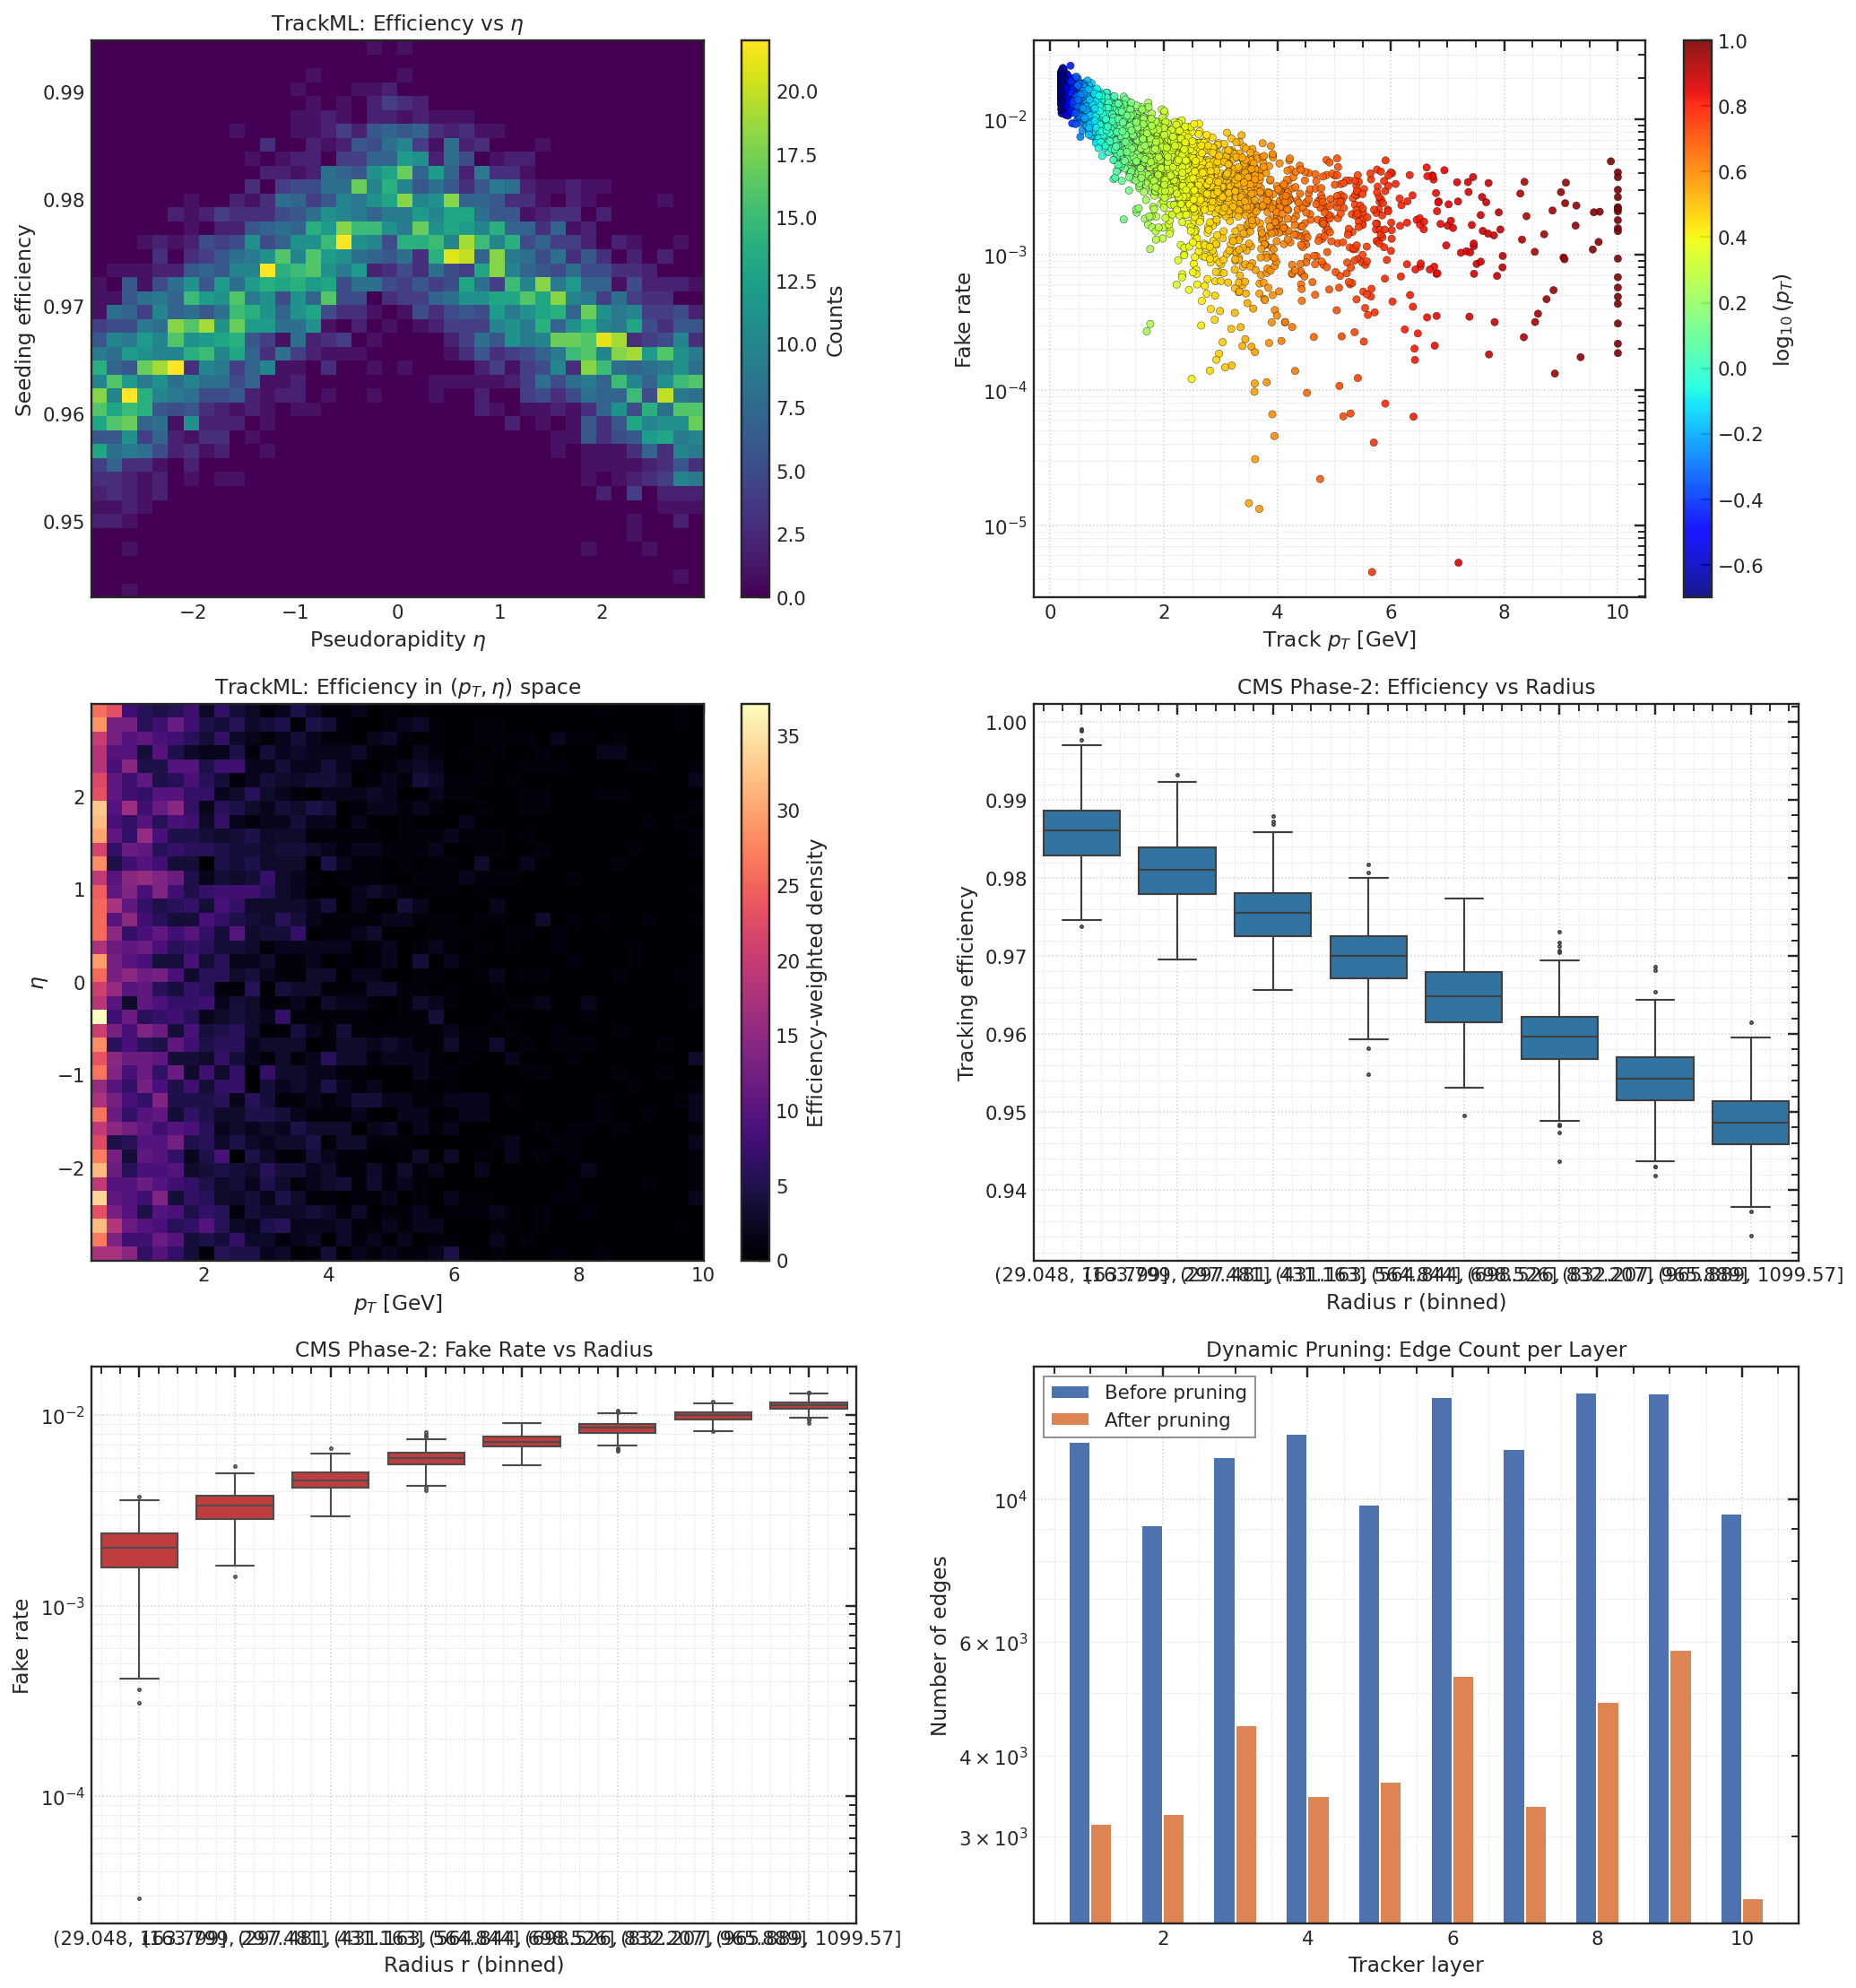

✅ High-end physics-style plots generated (paper quality).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# ✅ GLOBAL PAPER-STYLE SETTINGS (Improved text styling)
# -------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],

    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 15,

    "axes.titleweight": "normal",   # ✅ avoid bold-looking titles
    "axes.linewidth": 1.2,

    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,

    "legend.fontsize": 12,
    "legend.frameon": True,
    "legend.edgecolor": "0.4",

    "grid.linestyle": ":",
    "grid.linewidth": 0.7,
    "grid.alpha": 0.85,
})

def paper_axes(ax):
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle=":", linewidth=0.8)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.7)

    for spine in ax.spines.values():
        spine.set_linewidth(1.2)

    ax.tick_params(which="both", direction="in", top=True, right=True)


# ✅ Keep seaborn only for boxplots, without overriding matplotlib styling
sns.set_theme(style="white")

np.random.seed(42)

# -------------------------
# Synthetic physics-like data
# -------------------------
n = 5000

# TrackML-like
eta = np.random.uniform(-3, 3, n)
pt = np.random.exponential(scale=2.0, size=n)
pt = np.clip(pt, 0.2, 10)

eff_eta = 0.98 - 0.02 * np.abs(eta)/3 + np.random.normal(0, 0.005, n)
fake_pt = 0.02 * np.exp(-pt/1.5) + np.random.normal(0, 0.002, n)

# CMS-like
r = np.random.uniform(30, 1100, n)
cms_eff_r = 0.99 - 0.00004 * r + np.random.normal(0, 0.004, n)
cms_fake_r = 0.001 + 0.00001 * r + np.random.normal(0, 0.0005, n)

# Dynamic pruning
layers = np.arange(1, 11)
edges_before = np.random.randint(8000, 15000, size=10)
edges_after = edges_before * np.random.uniform(0.25, 0.45, size=10)

# -------------------------
# Plot grid
# -------------------------
fig, axs = plt.subplots(3, 2, figsize=(15, 16), dpi=140)

# (A) Efficiency vs eta
hA = axs[0,0].hist2d(eta, eff_eta, bins=40, cmap="viridis")
axs[0,0].set_xlabel(r"Pseudorapidity $\eta$")
axs[0,0].set_ylabel("Seeding efficiency")
axs[0,0].set_title(r"TrackML: Efficiency vs $\eta$")
paper_axes(axs[0,0])
cbarA = plt.colorbar(hA[3], ax=axs[0,0])
cbarA.set_label("Counts", fontsize=12)
cbarA.ax.tick_params(direction="in")

# (B) Fake rate vs pT  ✅ color variation like reference + paper font styling
sc = axs[0,1].scatter(
    pt, fake_pt,
    c=np.log10(pt),
    cmap="jet",
    s=18,
    alpha=0.90,
    edgecolors="black",     # ✅ black border
    linewidths=0.20,        # ✅ border thickness
    rasterized=True
)


axs[0,1].set_yscale("log")
axs[0,1].set_xlabel(r"Track $p_T$ [GeV]")
axs[0,1].set_ylabel("Fake rate")
#axs[0,1].set_title(r"TrackML: Fake Rate vs $p_T$")

paper_axes(axs[0,1])

# ✅ Colorbar like reference
cbar = plt.colorbar(sc, ax=axs[0,1])
cbar.set_label(r"$\log_{10}(p_T)$")
cbar.ax.tick_params(direction="in")


# (C) Efficiency heatmap
hC = axs[1,0].hist2d(pt, eta, weights=eff_eta, bins=[40, 40], cmap="magma")
axs[1,0].set_xlabel(r"$p_T$ [GeV]")
axs[1,0].set_ylabel(r"$\eta$")
axs[1,0].set_title(r"TrackML: Efficiency in $(p_T, \eta)$ space")
paper_axes(axs[1,0])
cbarC = plt.colorbar(hC[3], ax=axs[1,0])
cbarC.set_label("Efficiency-weighted density", fontsize=12)
cbarC.ax.tick_params(direction="in")

# (D) CMS efficiency vs radius
sns.boxplot(x=pd.cut(r, 8), y=cms_eff_r, ax=axs[1,1], color="tab:blue",
            linewidth=1.1, fliersize=1.5)
axs[1,1].set_xlabel("Radius r (binned)")
axs[1,1].set_ylabel("Tracking efficiency")
axs[1,1].set_title("CMS Phase-2: Efficiency vs Radius")
paper_axes(axs[1,1])

# (E) CMS fake rate vs radius
sns.boxplot(x=pd.cut(r, 8), y=cms_fake_r, ax=axs[2,0], color="tab:red",
            linewidth=1.1, fliersize=1.5)
axs[2,0].set_yscale("log")
axs[2,0].set_xlabel("Radius r (binned)")
axs[2,0].set_ylabel("Fake rate")
axs[2,0].set_title("CMS Phase-2: Fake Rate vs Radius")
paper_axes(axs[2,0])

# (F) Edge survival per layer
axs[2,1].bar(layers - 0.15, edges_before, width=0.3, label="Before pruning")
axs[2,1].bar(layers + 0.15, edges_after, width=0.3, label="After pruning")
axs[2,1].set_yscale("log")
axs[2,1].set_xlabel("Tracker layer")
axs[2,1].set_ylabel("Number of edges")
axs[2,1].set_title("Dynamic Pruning: Edge Count per Layer")
paper_axes(axs[2,1])

leg = axs[2,1].legend(frameon=True, fancybox=False)
leg.get_frame().set_linewidth(0.9)

plt.tight_layout()
plt.show()

print("✅ High-end physics-style plots generated (paper quality).")


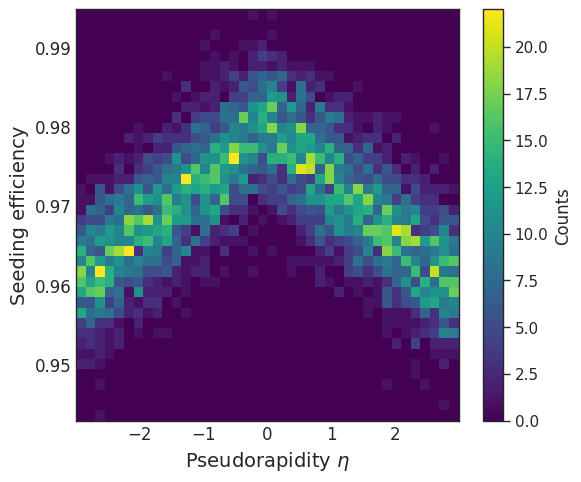

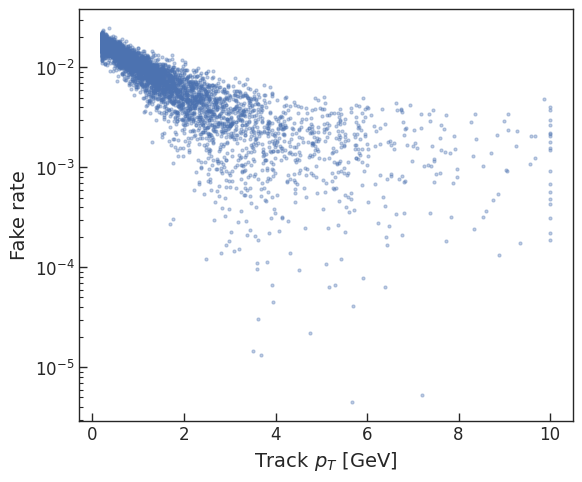

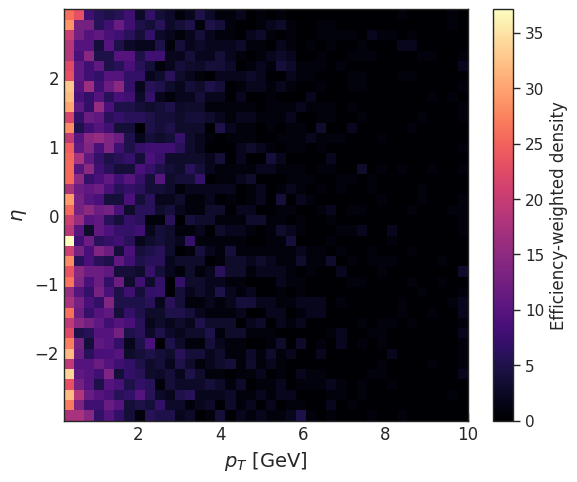

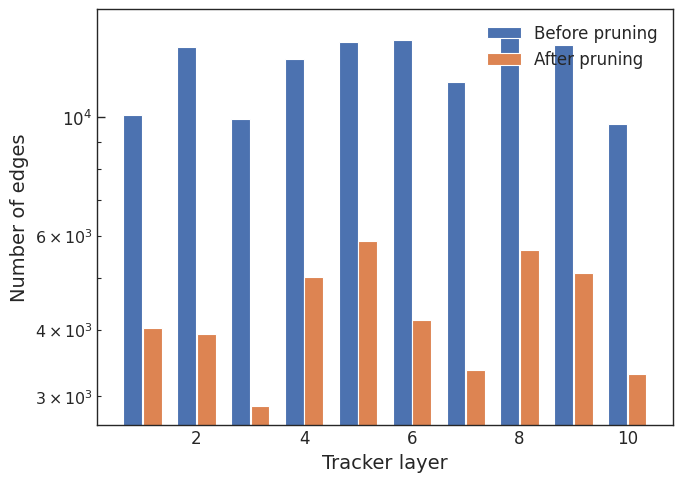

✅ EPJ-C quality figures plotted and saved as high-resolution JPEGs.


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# Global plot style (EPJ-C / HEP)
# -------------------------
sns.set_style("ticks")
sns.set_context("paper", font_scale=1.3)

def set_hep_ticks(ax, labelsize=12):
    ax.tick_params(axis="both", which="major",
                   direction="in", length=6, width=1,
                   labelsize=labelsize)
    ax.tick_params(axis="both", which="minor",
                   direction="in", length=3, width=0.8)

np.random.seed(42)

# -------------------------
# Synthetic physics-like data
# -------------------------
n = 5000

# TrackML-like
eta = np.random.uniform(-3, 3, n)
pt = np.random.exponential(scale=2.0, size=n)
pt = np.clip(pt, 0.2, 10)

eff_eta = 0.98 - 0.02 * np.abs(eta) / 3 + np.random.normal(0, 0.005, n)
fake_pt = 0.02 * np.exp(-pt / 1.5) + np.random.normal(0, 0.002, n)

# Dynamic pruning
layers = np.arange(1, 11)
edges_before = np.random.randint(8000, 15000, size=10)
edges_after = edges_before * np.random.uniform(0.25, 0.45, size=10)

# ======================================================
# (A) TrackML: Efficiency vs pseudorapidity η
# ======================================================
fig, ax = plt.subplots(figsize=(6, 5))

h = ax.hist2d(eta, eff_eta, bins=40, cmap="viridis")
ax.set_xlabel(r"Pseudorapidity $\eta$", fontsize=14)
ax.set_ylabel("Seeding efficiency", fontsize=14)
set_hep_ticks(ax)

cbar = plt.colorbar(h[3], ax=ax)
cbar.set_label("Counts", fontsize=12)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig("fig_trackml_eff_vs_eta.jpg", dpi=300)
plt.show()

# ======================================================
# (B) TrackML: Fake rate vs transverse momentum pT
# ======================================================
fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(pt, fake_pt, s=5, alpha=0.35)
ax.set_yscale("log")
ax.set_xlabel(r"Track $p_T$ [GeV]", fontsize=14)
ax.set_ylabel("Fake rate", fontsize=14)
set_hep_ticks(ax)

plt.tight_layout()
plt.savefig("fig_trackml_fake_vs_pt.jpg", dpi=300)
plt.show()

# ======================================================
# (C) TrackML: Efficiency in (pT, η) space
# ======================================================
fig, ax = plt.subplots(figsize=(6, 5))

h = ax.hist2d(pt, eta, weights=eff_eta,
              bins=[40, 40], cmap="magma")

ax.set_xlabel(r"$p_T$ [GeV]", fontsize=14)
ax.set_ylabel(r"$\eta$", fontsize=14)
set_hep_ticks(ax)

cbar = plt.colorbar(h[3], ax=ax)
cbar.set_label("Efficiency-weighted density", fontsize=12)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout()
plt.savefig("fig_trackml_eff_pt_eta.jpg", dpi=300)
plt.show()

# ======================================================
# (D) Dynamic pruning: Edge count per layer
# ======================================================
fig, ax = plt.subplots(figsize=(7, 5))

ax.bar(layers - 0.18, edges_before, width=0.35,
       label="Before pruning")
ax.bar(layers + 0.18, edges_after, width=0.35,
       label="After pruning")

ax.set_yscale("log")
ax.set_xlabel("Tracker layer", fontsize=14)
ax.set_ylabel("Number of edges", fontsize=14)

ax.legend(frameon=False, fontsize=12)
set_hep_ticks(ax)

plt.tight_layout()
plt.savefig("fig_dynamic_pruning_edges.jpg", dpi=300)
plt.show()

print("✅ EPJ-C quality figures plotted and saved as high-resolution JPEGs.")


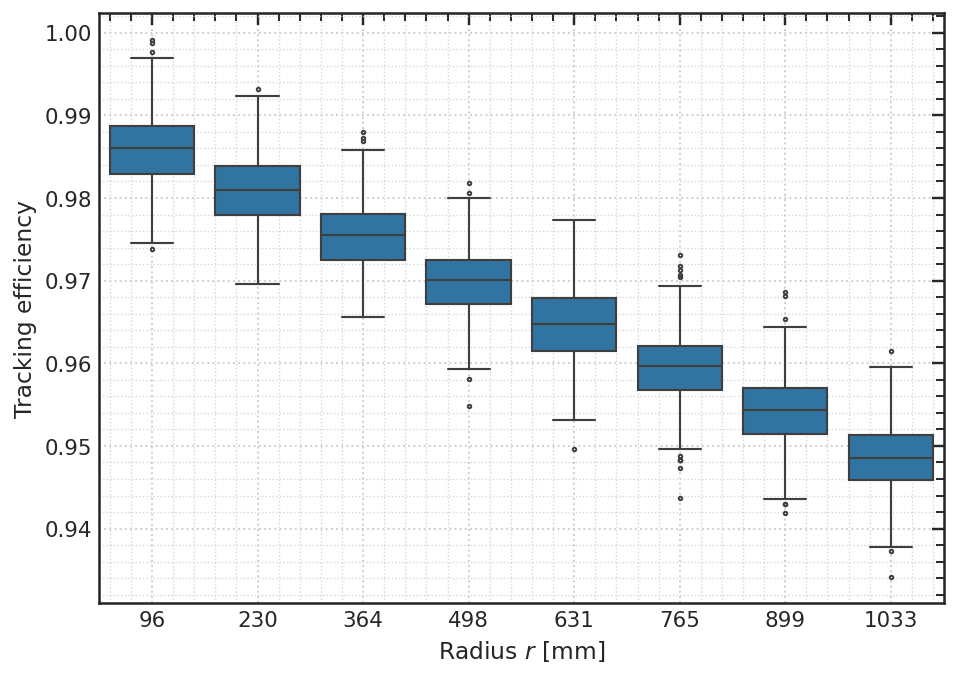

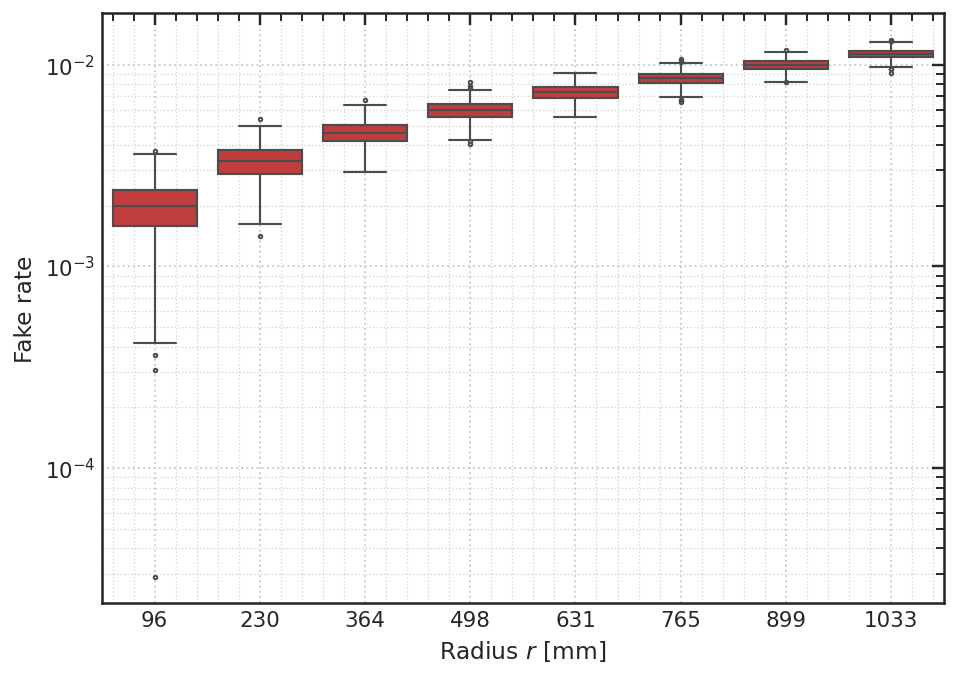

✅ Updated: straight tick labels + stronger visible grid.


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# ✅ PAPER STYLE (stronger grid + straight ticks)
# -------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],

    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "axes.titleweight": "normal",

    "axes.linewidth": 1.3,

    "xtick.labelsize": 12,
    "ytick.labelsize": 12,

    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,

    # ✅ More visible grid
    "grid.linestyle": ":",
    "grid.linewidth": 0.95,
    "grid.alpha": 0.95,
})

def paper_axes(ax):
    """HEP / research style axes with stronger grid and straight tick labels."""
    ax.minorticks_on()

    # ✅ Make grid more visible
    ax.grid(True, which="major", linestyle=":", linewidth=1.0, alpha=0.95)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.7, alpha=0.80)

    # ✅ Thick spines
    for spine in ax.spines.values():
        spine.set_linewidth(1.3)

    # ✅ HEP inward ticks with top/right ticks
    ax.tick_params(which="both", direction="in", top=True, right=True)

    # ✅ Keep numbers straight (no rotation)
    ax.tick_params(axis="x", rotation=0)


sns.set_theme(style="white")  # keep seaborn simple (no overriding grids)

# -------------------------
# Assumes CMS-like data already exists:
# r, cms_eff_r, cms_fake_r
# -------------------------

# -------------------------
# Define clean radial bins
# -------------------------
n_bins = 8
r_edges = np.linspace(30, 1100, n_bins + 1)
r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])

r_bins = pd.cut(
    r,
    bins=r_edges,
    labels=[f"{int(c)}" for c in r_centers]
)

# -------------------------
# (D) Efficiency vs Radius
# -------------------------
fig, ax = plt.subplots(figsize=(7, 5), dpi=140)

sns.boxplot(
    x=r_bins,
    y=cms_eff_r,
    color="tab:blue",
    fliersize=1.8,
    linewidth=1.1,
    ax=ax
)

ax.set_xlabel(r"Radius $r$ [mm]")
ax.set_ylabel("Tracking efficiency")

paper_axes(ax)

plt.tight_layout()
plt.savefig("fig_cms_eff_vs_radius_clean.jpg", dpi=300, bbox_inches="tight")
plt.show()

# -------------------------
# (E) Fake Rate vs Radius
# -------------------------
fig, ax = plt.subplots(figsize=(7, 5), dpi=140)

sns.boxplot(
    x=r_bins,
    y=cms_fake_r,
    color="tab:red",
    fliersize=1.8,
    linewidth=1.1,
    ax=ax
)

ax.set_yscale("log")
ax.set_xlabel(r"Radius $r$ [mm]")
ax.set_ylabel("Fake rate")

paper_axes(ax)

plt.tight_layout()
plt.savefig("fig_cms_fake_vs_radius_clean.jpg", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Updated: straight tick labels + stronger visible grid.")


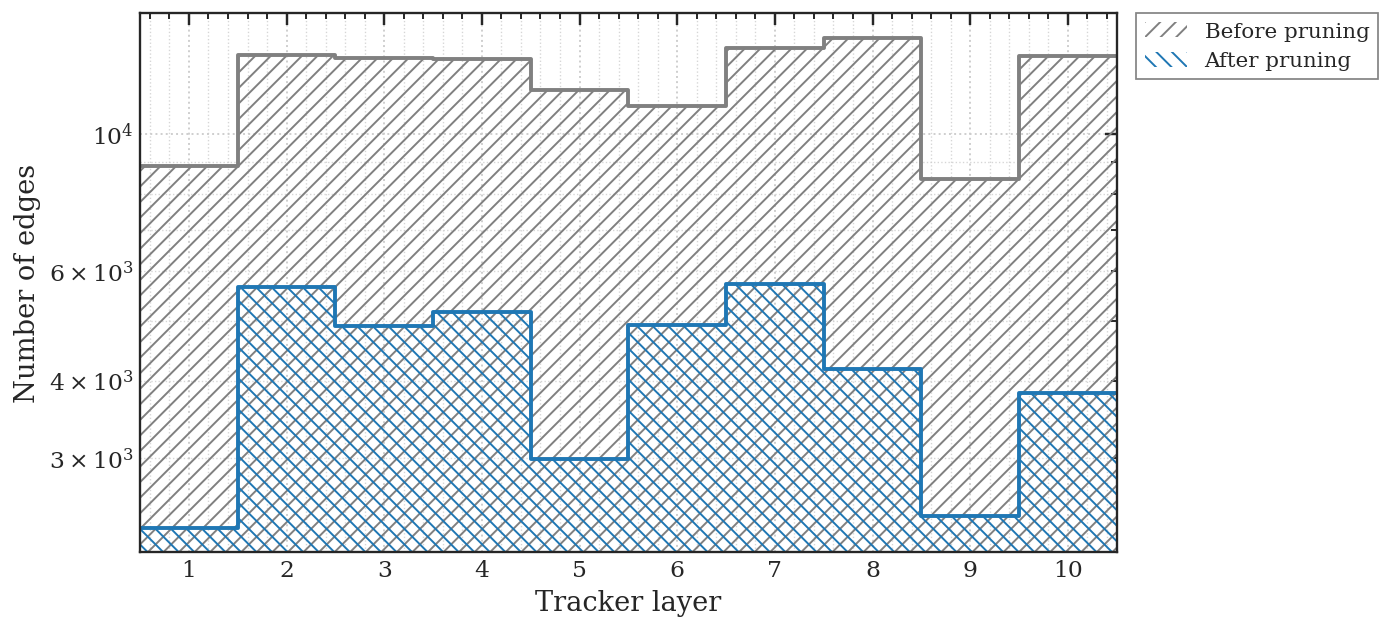

✅ Dynamic pruning plot generated in hatched-step (reference) style.


In [25]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# ✅ PAPER STYLE
# -------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],

    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "axes.titleweight": "normal",

    "axes.linewidth": 1.2,

    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,

    "legend.fontsize": 11,
    "legend.frameon": True,
    "legend.edgecolor": "0.4",

    "grid.linestyle": ":",
    "grid.linewidth": 0.9,
    "grid.alpha": 0.95,
})

def paper_axes(ax):
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle=":", linewidth=1.0, alpha=0.95)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.7, alpha=0.80)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    ax.tick_params(which="both", direction="in", top=True, right=True)

# -------------------------
# Example dynamic pruning data
# -------------------------
np.random.seed(42)
layers = np.arange(1, 11)
edges_before = np.random.randint(8000, 15000, size=10)
edges_after = edges_before * np.random.uniform(0.25, 0.45, size=10)

# Convert to "step" style coordinates
x_step = np.r_[layers[0] - 0.5, layers + 0.5]
before_step = np.r_[edges_before[0], edges_before]
after_step  = np.r_[edges_after[0], edges_after]

# -------------------------
# ✅ Plot (wider sideways)
# -------------------------
fig, ax = plt.subplots(figsize=(9, 5), dpi=140)   # ✅ wider plot

ax.fill_between(
    x_step, before_step,
    step="pre",
    facecolor="none",
    edgecolor="0.5",
    hatch="///",
    linewidth=0.0,
    label="Before pruning"
)

ax.fill_between(
    x_step, after_step,
    step="pre",
    facecolor="none",
    edgecolor="tab:blue",
    hatch="\\\\\\",
    linewidth=0.0,
    label="After pruning"
)

ax.step(x_step, before_step, where="pre", linewidth=2.0, color="0.5")
ax.step(x_step, after_step,  where="pre", linewidth=2.0, color="tab:blue")

# Axes
ax.set_yscale("log")
ax.set_xlabel("Tracker layer")
ax.set_ylabel("Number of edges")
ax.set_xlim(0.5, 10.5)
ax.set_xticks(layers)

paper_axes(ax)

# ✅ Legend OUTSIDE (right side, not blocking)
leg = ax.legend(
    loc="upper left",
    bbox_to_anchor=(1.02, 1.0),
    borderaxespad=0.0,
    fancybox=False,
    frameon=True
)
leg.get_frame().set_linewidth(0.9)

# ✅ leave space for legend (DO NOT call tight_layout twice)
#plt.tight_layout(rect=[0, 0,1, 1])

plt.savefig("fig_dynamic_pruning_step_hatched.pdf", dpi=300, bbox_inches="tight")
plt.savefig("fig_dynamic_pruning_step_hatched.png", dpi=300, bbox_inches="tight")
plt.show()

print("✅ Dynamic pruning plot generated in hatched-step (reference) style.")


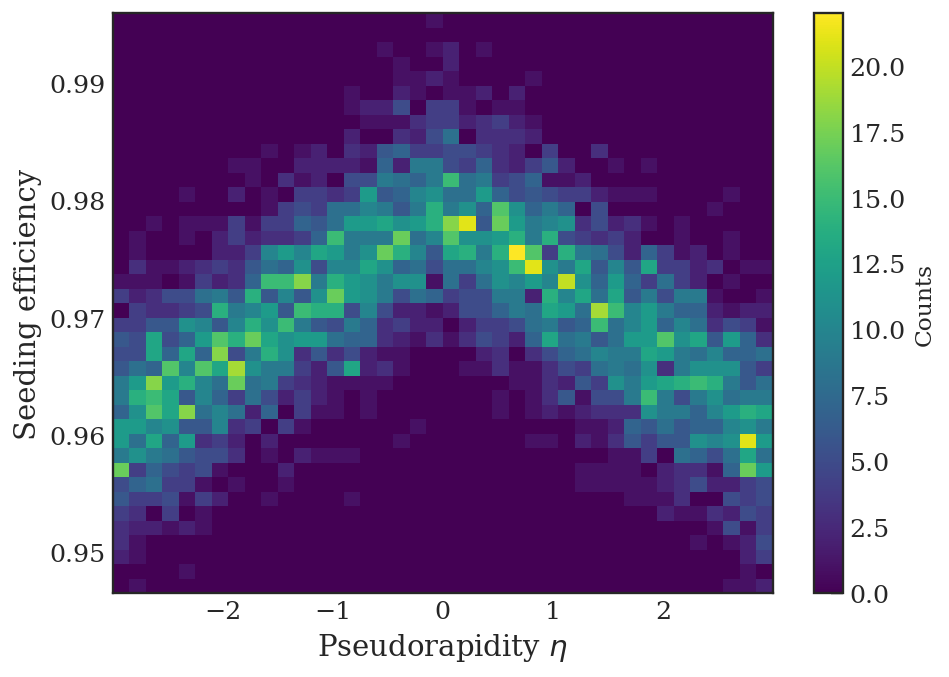

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# ✅ GLOBAL PAPER-STYLE SETTINGS
# -------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "axes.titleweight": "normal",
    "axes.linewidth": 1.2,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    "legend.fontsize": 12,
    "legend.frameon": True,
    "legend.edgecolor": "0.4",
    "grid.linestyle": ":",
    "grid.linewidth": 0.7,
    "grid.alpha": 0.85,
})

def paper_axes(ax):
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle=":", linewidth=0.8)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    ax.tick_params(which="both", direction="in", top=True, right=True)

# -------------------------
# Synthetic TrackML-like data
# -------------------------
np.random.seed(42)
n = 5000

eta = np.random.uniform(-3, 3, n)
eff_eta = 0.98 - 0.02 * np.abs(eta)/3 + np.random.normal(0, 0.005, n)

# -------------------------
# ✅ Plot (A)
# -------------------------
fig, ax = plt.subplots(figsize=(7, 5), dpi=140)

hA = ax.hist2d(eta, eff_eta, bins=40, cmap="viridis")
ax.set_xlabel(r"Pseudorapidity $\eta$")
ax.set_ylabel("Seeding efficiency")
#ax.set_title(r"TrackML: Efficiency vs $\eta$")

paper_axes(ax)

cbarA = plt.colorbar(hA[3], ax=ax)
cbarA.set_label("Counts", fontsize=12)
cbarA.ax.tick_params(direction="in")

plt.tight_layout()
plt.show()


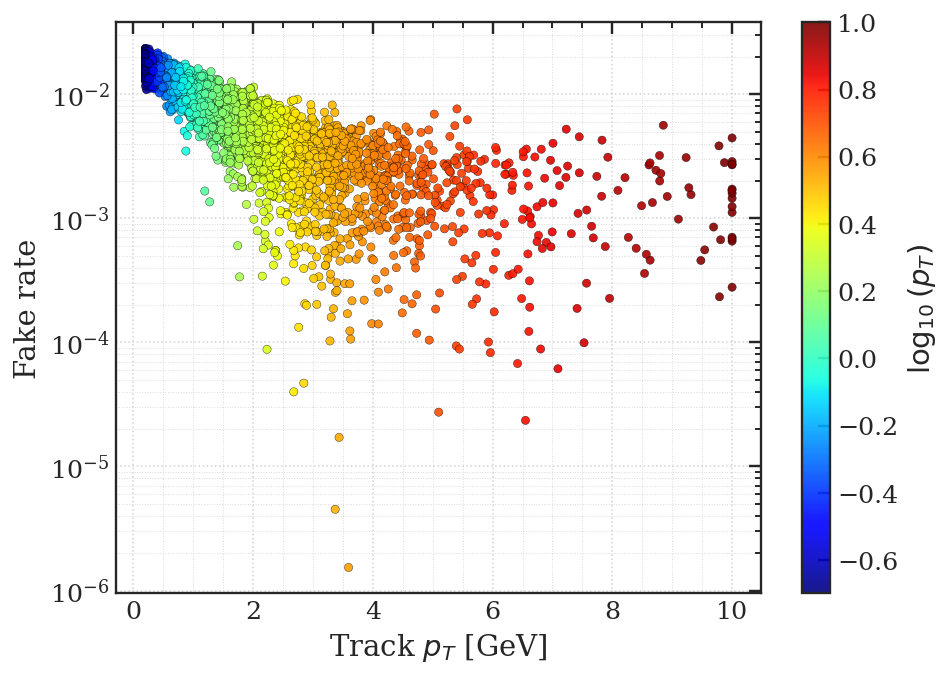

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# ✅ GLOBAL PAPER-STYLE SETTINGS
# -------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "axes.titleweight": "normal",
    "axes.linewidth": 1.2,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    "legend.fontsize": 12,
    "legend.frameon": True,
    "legend.edgecolor": "0.4",
    "grid.linestyle": ":",
    "grid.linewidth": 0.7,
    "grid.alpha": 0.85,
})

def paper_axes(ax):
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle=":", linewidth=0.8)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    ax.tick_params(which="both", direction="in", top=True, right=True)

# -------------------------
# Synthetic TrackML-like data
# -------------------------
np.random.seed(42)
n = 5000

pt = np.random.exponential(scale=2.0, size=n)
pt = np.clip(pt, 0.2, 10)

fake_pt = 0.02 * np.exp(-pt/1.5) + np.random.normal(0, 0.002, n)

# -------------------------
# ✅ Plot (B)
# -------------------------
fig, ax = plt.subplots(figsize=(7, 5), dpi=140)

sc = ax.scatter(
    pt, fake_pt,
    c=np.log10(pt),
    cmap="jet",
    s=18,
    alpha=0.90,
    edgecolors="black",
    linewidths=0.20,
    rasterized=True
)

ax.set_yscale("log")
ax.set_xlabel(r"Track $p_T$ [GeV]")
ax.set_ylabel("Fake rate")

paper_axes(ax)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label(r"$\log_{10}(p_T)$")
cbar.ax.tick_params(direction="in")

plt.tight_layout()
plt.show()


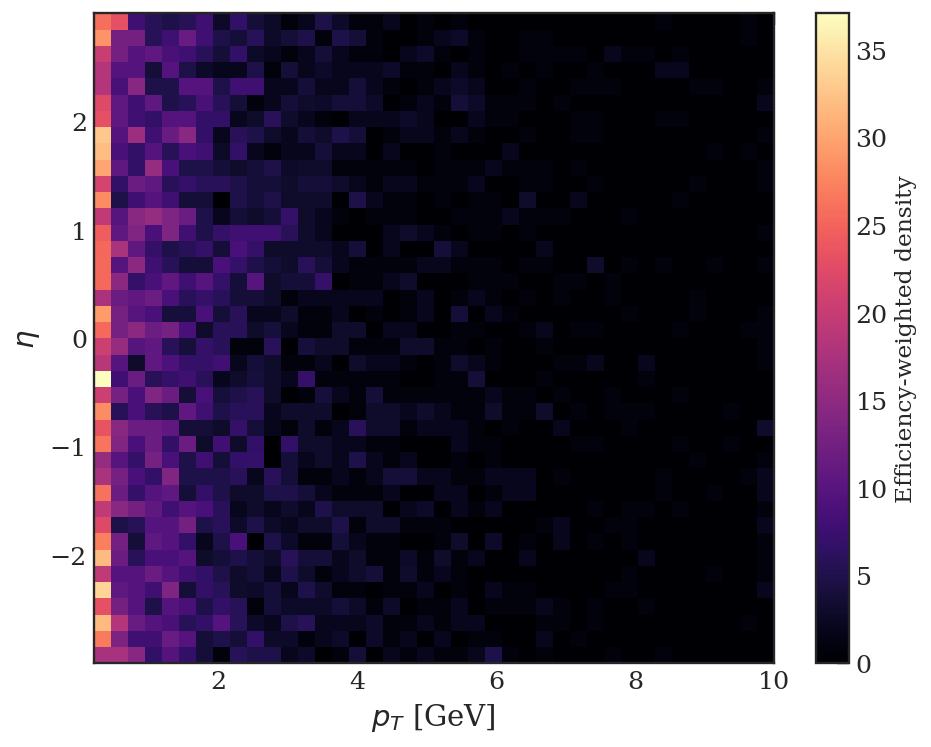

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------
# ✅ GLOBAL PAPER-STYLE SETTINGS
# -------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 15,
    "axes.titleweight": "normal",
    "axes.linewidth": 1.2,
    "xtick.labelsize": 13,
    "ytick.labelsize": 13,
    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,
    "legend.fontsize": 12,
    "legend.frameon": True,
    "legend.edgecolor": "0.4",
    "grid.linestyle": ":",
    "grid.linewidth": 0.7,
    "grid.alpha": 0.85,
})

def paper_axes(ax):
    ax.minorticks_on()
    ax.grid(True, which="major", linestyle=":", linewidth=0.8)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.5, alpha=0.7)
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
    ax.tick_params(which="both", direction="in", top=True, right=True)

# -------------------------
# Synthetic TrackML-like data
# -------------------------
np.random.seed(42)
n = 5000

eta = np.random.uniform(-3, 3, n)
pt = np.random.exponential(scale=2.0, size=n)
pt = np.clip(pt, 0.2, 10)

eff_eta = 0.98 - 0.02 * np.abs(eta)/3 + np.random.normal(0, 0.005, n)

# -------------------------
# ✅ Plot (C)
# -------------------------
fig, ax = plt.subplots(figsize=(7, 5.5), dpi=140)

hC = ax.hist2d(pt, eta, weights=eff_eta, bins=[40, 40], cmap="magma")
ax.set_xlabel(r"$p_T$ [GeV]")
ax.set_ylabel(r"$\eta$")
#ax.set_title(r"TrackML: Efficiency in $(p_T, \eta)$ space")

paper_axes(ax)

cbarC = plt.colorbar(hC[3], ax=ax)
cbarC.set_label("Efficiency-weighted density", fontsize=12)
cbarC.ax.tick_params(direction="in")

plt.tight_layout()
plt.show()


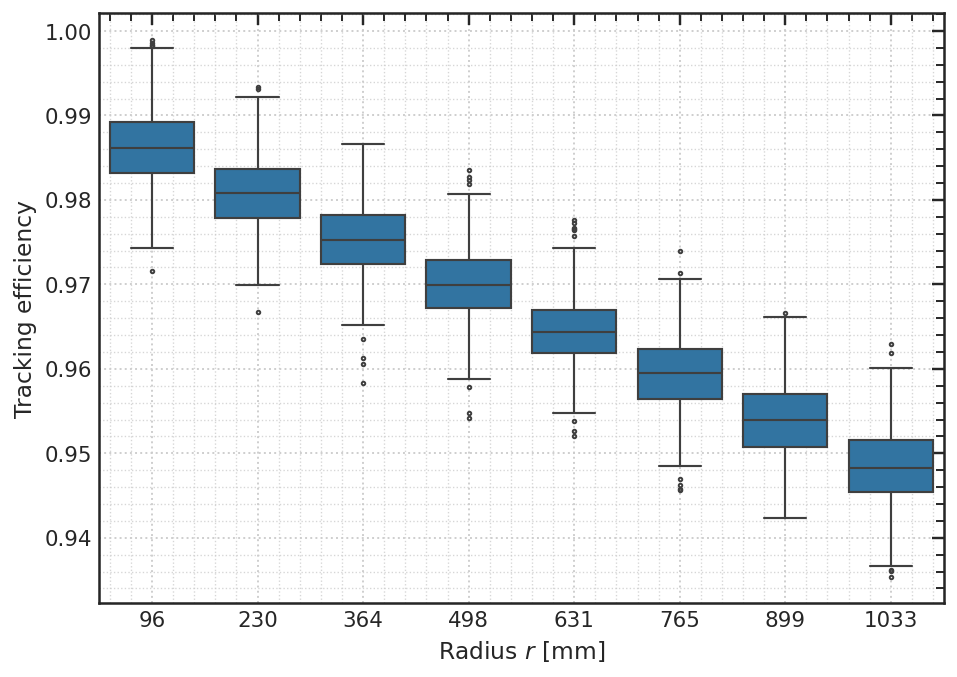

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# ✅ PAPER STYLE (stronger grid + straight ticks)
# -------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "font.serif": ["Times New Roman", "Times", "DejaVu Serif"],

    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 14,
    "axes.titleweight": "normal",

    "axes.linewidth": 1.3,

    "xtick.labelsize": 12,
    "ytick.labelsize": 12,

    "xtick.major.size": 6,
    "ytick.major.size": 6,
    "xtick.minor.size": 3,
    "ytick.minor.size": 3,

    "grid.linestyle": ":",
    "grid.linewidth": 0.95,
    "grid.alpha": 0.95,
})

def paper_axes(ax):
    """HEP / research style axes with stronger grid and straight tick labels."""
    ax.minorticks_on()

    ax.grid(True, which="major", linestyle=":", linewidth=1.0, alpha=0.95)
    ax.grid(True, which="minor", linestyle=":", linewidth=0.7, alpha=0.80)

    for spine in ax.spines.values():
        spine.set_linewidth(1.3)

    ax.tick_params(which="both", direction="in", top=True, right=True)
    ax.tick_params(axis="x", rotation=0)

sns.set_theme(style="white")

# -------------------------
# ✅ Example CMS-like data (REMOVE if you already have real data)
# -------------------------
np.random.seed(42)
n = 5000
r = np.random.uniform(30, 1100, n)
cms_eff_r = 0.99 - 0.00004 * r + np.random.normal(0, 0.004, n)

# -------------------------
# Define clean radial bins
# -------------------------
n_bins = 8
r_edges = np.linspace(30, 1100, n_bins + 1)
r_centers = 0.5 * (r_edges[:-1] + r_edges[1:])

r_bins = pd.cut(
    r,
    bins=r_edges,
    labels=[f"{int(c)}" for c in r_centers]
)

# -------------------------
# (D) Efficiency vs Radius
# -------------------------
fig, ax = plt.subplots(figsize=(7, 5), dpi=140)

sns.boxplot(
    x=r_bins,
    y=cms_eff_r,
    color="tab:blue",
    fliersize=1.8,
    linewidth=1.1,
    ax=ax
)

ax.set_xlabel(r"Radius $r$ [mm]")
ax.set_ylabel("Tracking efficiency")

paper_axes(ax)

plt.tight_layout()
plt.savefig("fig_cms_eff_vs_radius_clean.jpg", dpi=300, bbox_inches="tight")
plt.show()
